In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import zipfile
import random
from shutil import copyfile

print(tf.__version__)

2.15.0


In [2]:
device_name = tf.test.gpu_device_name()
device_name

''

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  55.5M      0  0:00:14  0:00:14 --:--:-- 55.6M


In [4]:
import pathlib
data_dir = pathlib.Path("PetImages")

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Удаляем испорченные и не поддерживаемые изображения
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [7]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

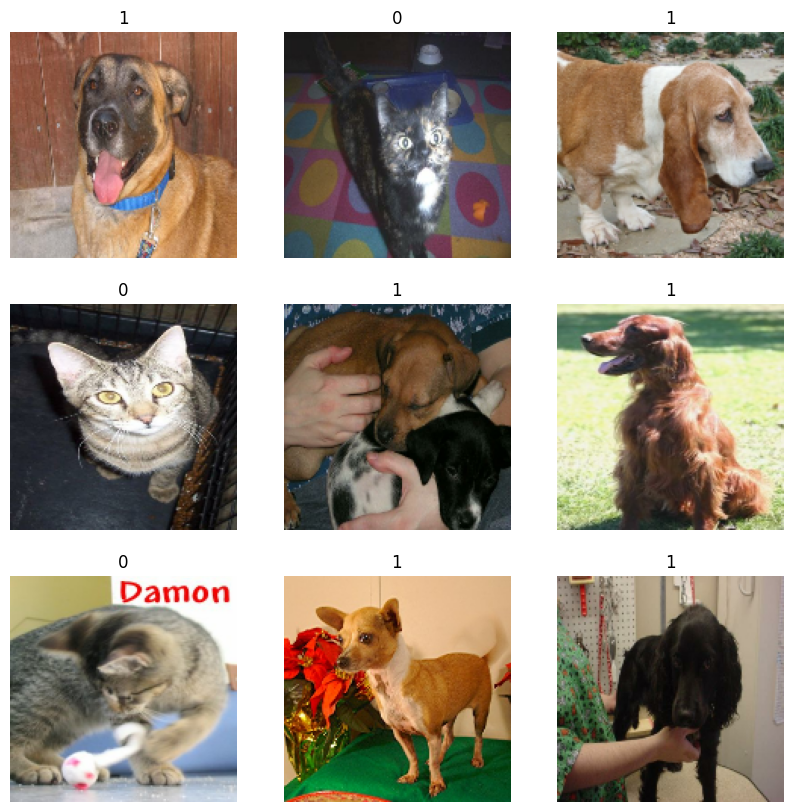

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        # tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.1),
        # tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.4),
        tf.keras.layers.GaussianNoise(0.5),
        # tf.keras.layers.RandomZoom(0.2),
        # tf.keras.layers.RandomTranslation(0.2, 0.2),
    ]
)

In [10]:
train_ds_take = train_ds.take(1)

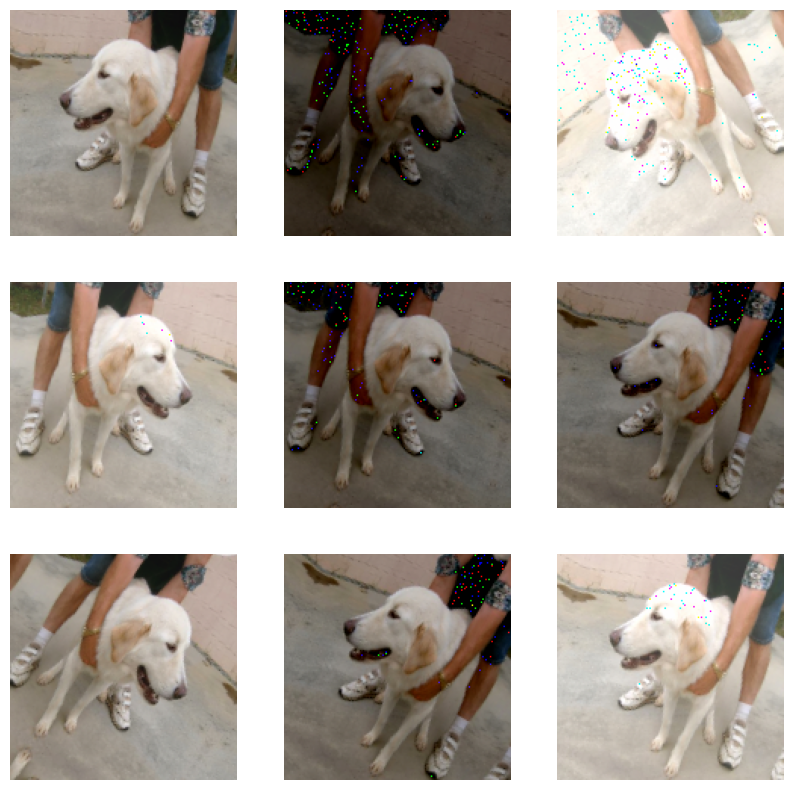

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds_take:
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
# augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),  # Additional dense layer
    tf.keras.layers.Dropout(0.3),  # Add dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                      

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=300, verbose=1)

Epoch 1/300
586/586 [==============================] - 1319s 2s/step - loss: 0.7000 - accuracy: 0.5010 - val_loss: 0.6911 - val_accuracy: 0.5645
Epoch 2/300
 10/586 [..............................] - ETA: 18:56 - loss: 0.6923 - accuracy: 0.5000

In [ ]:
model.save("model_impressive_accuracy")

In [ ]:
def learning_curves(history, epochs):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))
    legend1 = ax1.legend(loc='best', shadow=True)

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend2 = ax2.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()


In [ ]:
learning_curves(history, 10)

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.8,
    subset="validation",
    seed=1,
    image_size=image_size,
    batch_size=batch_size,
)

test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")